In [1]:
!nvidia-smi

Sat Dec 31 20:23:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:00:05.0 Off |                  N/A |
| 30%   26C    P8     1W / 125W |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow_datasets==4.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 21.9 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=98bf209868bf54656d93271da6e362fcdbc7a0bf8a3f572123a3e4831c632a64
  Stored in directory: /root/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflic

In [181]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, GlobalMaxPool2D, MaxPool2D, AvgPool2D, Dense, TimeDistributed, LSTM, Flatten, Dropout, BatchNormalization, RNN, LSTMCell, AbstractRNNCell

In [4]:
ds_train, ds_test = tfds.load('mnist', 
                              split=['train', 'test'], 
                              as_supervised=True, 
                              shuffle_files=True)

2022-12-31 20:23:17.840325: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [117]:
# create list of alternating 1 and -1
def alternate_sign(n):
  return [-1 if i % 2 else 1 for i in range(n)]

def pipeline(ds, sequence_length = 4, batch_size=32):
  alternating_sequence = alternate_sign(sequence_length)
  
  # normalize images and convert types
  ds = ds.map(lambda img, label: (tf.cast(img, tf.float32), (tf.cast(label, tf.int32)))) \
         .map(lambda img, label: (img / 128.0 - 1.0, label))
  
  # shifting window
  ds = ds.window(sequence_length, drop_remainder=True) \
         .map(lambda img, label: (img.batch(sequence_length).get_single_element(), label.batch(sequence_length).get_single_element()))
 
  # calculate alternating digits 
  ds = ds.map(lambda img, target: (img, tf.math.multiply(target, alternating_sequence)))
  # cumulative sum for each individual element up to the current element
  ds = ds.map(lambda img, target: (img, tf.math.cumsum(target, axis=0)))
 
  ## shuffle and prefetch 
  ds = ds.batch(batch_size, drop_remainder=True) \
         .cache() \
         .shuffle(1000) \
         .prefetch(tf.data.AUTOTUNE)
  return ds

In [118]:
ds_train_piped = pipeline(ds_train)
ds_test_piped = pipeline(ds_test)

Shapes: (32, 4, 28, 28, 1), (32, 4), Label: [ 3  0  4 -4]
Shapes: (32, 4, 28, 28, 1), (32, 4), Label: [ 8 -1  0 -4]
Shapes: (32, 4, 28, 28, 1), (32, 4), Label: [ 4  4 12  5]
Shapes: (32, 4, 28, 28, 1), (32, 4), Label: [6 6 8 1]
Shapes: (32, 4, 28, 28, 1), (32, 4), Label: [ 3 -5 -5 -7]


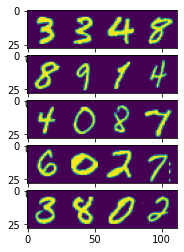

In [266]:
from matplotlib import pyplot as plt
NUM = 5
f, ax = plt.subplots(NUM, 1)
#for i in range(NUM):
for i, (img, label) in enumerate(ds_train_piped.take(NUM)):
  print(f'Shapes: {img.shape}, {label.shape}, Label: {label[0]}')

  img = tf.concat([img[0, i, ...] for i in range(4)], axis=1)
  ax[i].imshow(img)

In [269]:
class CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.layer_list = [
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
      TimeDistributed(MaxPool2D()),
      TimeDistributed(BatchNormalization()),
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      TimeDistributed(GlobalAvgPool2D()),
      Dropout(0.5),
      Dense(units=10, activation='relu')
    ]
    
  def call(self, x):
    for layer in self.layer_list:
      x = layer(x)
    return x
  
def try_model(model, ds):
  for images, labels in ds.take(1):
    print(model(images).shape)

In [270]:
try_model(CNN(), ds_train_piped)

(32, 4, 10)


In [271]:
from tensorflow.keras.initializers import Orthogonal

class LSTM(AbstractRNNCell):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)

        self.units = units

        self.forget = Dense(units, kernel_initializer=Orthogonal(gain=1.0, seed=None), activation='sigmoid')
        self.in1 = Dense(units, kernel_initializer=Orthogonal(gain=1.0, seed=None), activation='sigmoid')
        self.in2 = Dense(units, kernel_initializer=Orthogonal(gain=1.0, seed=None), activation='tanh')
        self.out = Dense(units, kernel_initializer=Orthogonal(gain=1.0, seed=None), activation='sigmoid')
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.units]), 
                tf.TensorShape([self.units])]

    def call(self, inputs, states):
        concat = tf.concat([inputs, states[1]], axis=-1)

        new_state = self.forget(concat) * states[0] + self.in1(concat) * self.in2(concat)
        new_hidden_state = self.out(concat) * tf.math.tanh(new_state)

        return new_hidden_state, (new_hidden_state, new_state)

In [272]:
class RNNM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.layer_list = [
            CNN(),
            RNN(LSTM(32), return_sequences=True, unroll=False),
            Dense(1),
        ]

    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [273]:
model = RNN()
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")])
history = model.fit(ds_train_piped, validation_data=ds_test_piped, epochs=15)

Epoch 1/15
468/468 [==============================] - 8s 13ms/step - loss: 22.7108 - acc: 0.4880 - val_loss: 19.2652 - val_acc: 0.5633
Epoch 2/15
468/468 [==============================] - 5s 11ms/step - loss: 13.7284 - acc: 0.7073 - val_loss: 8.1320 - val_acc: 0.7917
Epoch 3/15
468/468 [==============================] - 5s 11ms/step - loss: 8.7711 - acc: 0.7788 - val_loss: 7.0145 - val_acc: 0.8165
Epoch 4/15
468/468 [==============================] - 5s 11ms/step - loss: 7.4206 - acc: 0.7951 - val_loss: 5.4145 - val_acc: 0.8365
Epoch 5/15
468/468 [==============================] - 6s 12ms/step - loss: 6.5498 - acc: 0.8072 - val_loss: 6.3660 - val_acc: 0.8349
Epoch 6/15
468/468 [==============================] - 5s 11ms/step - loss: 5.9270 - acc: 0.8165 - val_loss: 4.7645 - val_acc: 0.8522
Epoch 7/15
468/468 [==============================] - 5s 11ms/step - loss: 5.5132 - acc: 0.8199 - val_loss: 4.2474 - val_acc: 0.8710
Epoch 8/15
468/468 [==============================] - 5s 11ms/step

<AxesSubplot:>

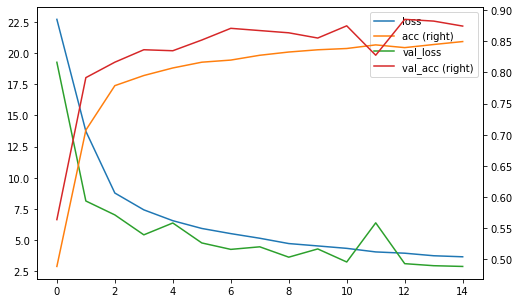

In [275]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5), secondary_y=['acc', 'val_acc'])